# Working with groundtruth models
In this notebook, I'll quickly generate a simple function that represents a cognitive task. Then I check if MSA can find the important units, and how well it performs with more distributed processes and larger number of elements.

In [1]:
# Uncomment the line below if you don't have them.
# !pip install networkx matplotlib seaborn

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# ---------
from msapy import msa, utils as ut, plottings as pl
# ---------
import matplotlib as mpl

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'GothamSSm'  # Will skip if you don't have Gotham typeface family
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 8
CM = 1 / 2.54
SEED = 111

## A very localized function
The task is, well, basically just a random generator! The idea is to draw a number from a normal distribution around some value, let's say 100 with standard deviation of 10. Then condition on lesioning some arbitrary element, there will be a deficit. For simulating a very localized "cognitive function" we can pass one element as the only cause. Passing more elements means this cognitive function is distributed across these elements so naturally we expect those to have the highest contributions while the others settle around zero. 

In [3]:
ground_truth_elements = ['a','b','c','d','e','f','g','h'] # our brain regions, for example!
print(f'total number of possible lesions: {2**len(ground_truth_elements)}')

total number of possible lesions: 256


As you can see, the number of lesions are not "that large" so we can exhauste the combination space.

In [4]:
ground_truth_cause = ['a'] # the cognitive function is the product of just one element 'a'

In [5]:
def gt(complements, causes):
    # default score, on average, is 100.
    score = np.random.normal(loc=100, scale=10)
    
    # checking if the regions of interest are being lesioned.
    if len(causes) != 0 and set(causes).issubset(complements):
        
        # lesioning ends with a reduction of 50 points.
        return score - 50 
    else:
        return score

In [6]:
shapley_table, _, _ = msa.interface(
    elements=ground_truth_elements,
    n_permutations=1_000,
    objective_function=gt,
    n_parallel_games=-1, #parallelized over all CPU cores
    objective_function_params={'causes': ground_truth_cause},
    random_seed=SEED)

Playing the games: 100%|██████████| 256/256 [00:00<00:00, 633.02it/s]


To quantify how much the function is distributed in our system, we can use this nifty function called "distribution_of_processing" in the utils module.
You can read more about it here:
 - Aharonov, R., Segev, L., Meilijson, I., & Ruppin, E. 2003. Localization of function via lesion analysis. Neural Computation.
 - Saggie-Wexler, Keren, Alon Keinan, and Eytan Ruppin. 2006. Neural Processing of Counting in Evolved Spiking and McCulloch-Pitts Agents. Artificial Life.

But the basic idea is to see how many units are involved in producing the function, one way or another, so negative Shapley values (interpreted as hinderace) still counts. If the value is around zero, it means a localized function, which we expect here, and if it's around one, it suggests a distributed process. So far I couldn't get anything really around zero and I assume it's because of the noise in the datasets. I think it needs some rescaling but generally it's a nice metric and still, you can compare two values to see which process is more distributed and how much.

In [7]:
d = ut.distribution_of_processing(shapley_vector=shapley_table.mean())
print(f'D intex is: {d}')

D intex is: 0.18515974976681815


Text(0.5, 1.0, 'Shapley values of a ground-truth dataset with only 1 critical element')

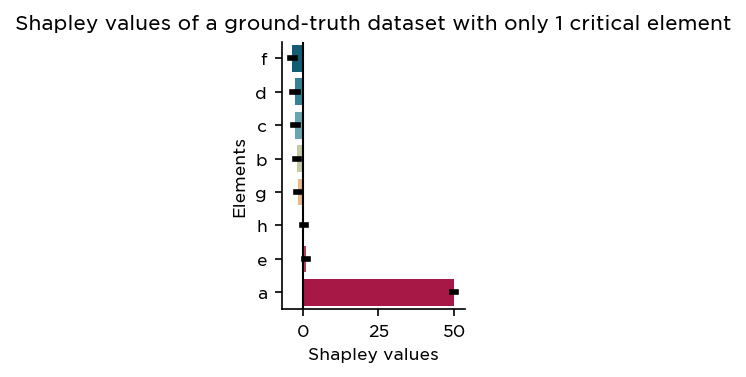

In [8]:
shapley_table = ut.sorter(shapley_table) # sorting based on the average contribution (Shapley values)

fig,ax = plt.subplots()
colors = pl.color_code(shapley_table=shapley_table)
pl.plot_shapley_ranks(shapley_table=shapley_table,colors=colors,ax=ax)
fig.set_dpi(150)
fig.set_size_inches((4*CM,6*CM))
plt.xlabel('Shapley values')
plt.ylabel('Elements')
plt.title('Shapley values of a ground-truth dataset with only 1 critical element')

Here's an interesting thing, pay attention to the Shapley value, it's around 50, which is the same number we mentioned for the performance deficit.

## A more distributed function
Here, we say the cognitive function relies on let's say 3 regions, if "all of these regions" are perturbed then the performance will drop by 50 points. The function we made stays the same, only the causes need an adjustment.

In [9]:
ground_truth_cause = ['a','b','c']

# The same call here:
shapley_table, _, _ = msa.interface(
    elements=ground_truth_elements,
    n_permutations=1_000,
    objective_function=gt,
    n_parallel_games=-1, #parallelized over all CPU cores
    objective_function_params={'causes': ground_truth_cause},
    random_seed=SEED)

Playing the games: 100%|██████████| 256/256 [00:00<00:00, 812.01it/s]


D intex is: 0.6386553422003425


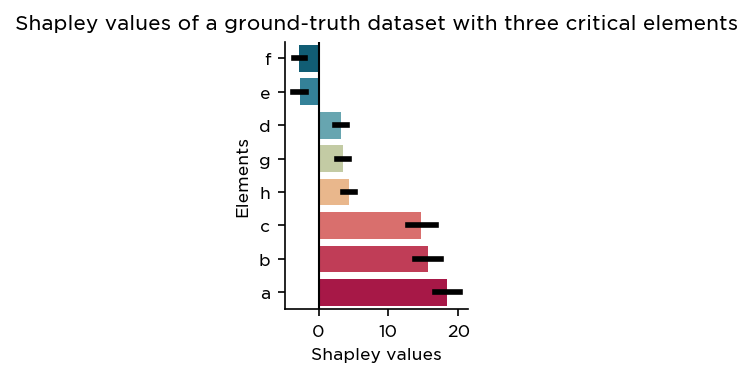

In [10]:
# The same pipeline here:
shapley_table = ut.sorter(shapley_table) # sorting based on the average contribution (Shapley values)

fig,ax = plt.subplots()
colors = pl.color_code(shapley_table=shapley_table)
pl.plot_shapley_ranks(shapley_table=shapley_table,colors=colors,ax=ax)
fig.set_dpi(150)
fig.set_size_inches((4*CM,6*CM))

plt.xlabel('Shapley values')
plt.ylabel('Elements')
plt.title('Shapley values of a ground-truth dataset with three critical elements')

# And the D index
d = ut.distribution_of_processing(shapley_vector=shapley_table.mean())
print(f'D intex is: {d}')

Again, the interesting point is Shapley values roughly correspond to 50/3, which is pretty neat.

## A totally distributed function
Yeah why not! let's say all except one unit is involved. Things will get tricky here and you'll see why!

In [11]:
ground_truth_cause = ['a','b','c','d','e','f','g'] #only 'h' is out.

# The same call here:
shapley_table, _, _ = msa.interface(
    elements=ground_truth_elements,
    n_permutations=1_000,
    objective_function=gt,
    n_parallel_games=-1, #parallelized over all CPU cores
    objective_function_params={'causes': ground_truth_cause},
    random_seed=SEED)

Playing the games: 100%|██████████| 256/256 [00:00<00:00, 906.99it/s]


D intex is: 0.7025646400839242


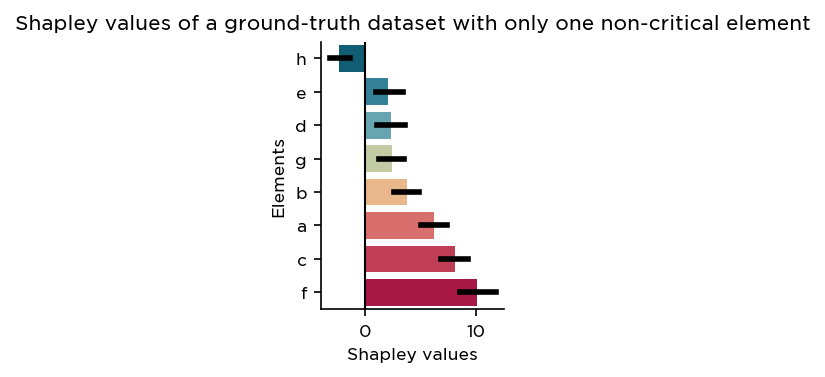

In [12]:
# The same pipeline here:
shapley_table = ut.sorter(shapley_table) # sorting based on the average contribution (Shapley values)

fig,ax = plt.subplots()
colors = pl.color_code(shapley_table=shapley_table)
pl.plot_shapley_ranks(shapley_table=shapley_table,colors=colors,ax=ax)
fig.set_dpi(150)
fig.set_size_inches((4*CM,6*CM))
plt.xlabel('Shapley values')
plt.ylabel('Elements')
plt.title('Shapley values of a ground-truth dataset with only one non-critical element')

# And the D index
d = ut.distribution_of_processing(shapley_vector=shapley_table.mean())
print(f'D intex is: {d}')

You see, still it captured the critical elements, but the importance is not equally distributed. I believe it's due to two things:

1. Noise in the performance. 
2. Noise in the estimation.

Let's get rid of the first and see if it makes a difference.

In [13]:
def gt_noisless(complements, causes):
    # default score, will be 100 sharp!
    score = 100
    
    # checking if the regions of interest are being lesioned.
    if len(causes) != 0 and set(causes).issubset(complements):
        
        # lesioning ends with a reduction of 50 points.
        return score - 50 
    else:
        return score

In [14]:
ground_truth_cause = ['a','b','c','d','e','f','g'] #only 'h' is out.

# The same call here:
shapley_table, _, _ = msa.interface(
    elements=ground_truth_elements,
    n_permutations=1_000,
    objective_function=gt_noisless,
    n_parallel_games=-1, #parallelized over all CPU cores
    objective_function_params={'causes': ground_truth_cause},
    random_seed=SEED)

Playing the games: 100%|██████████| 256/256 [00:00<00:00, 1072.05it/s]


D intex is: 0.8562401827212132


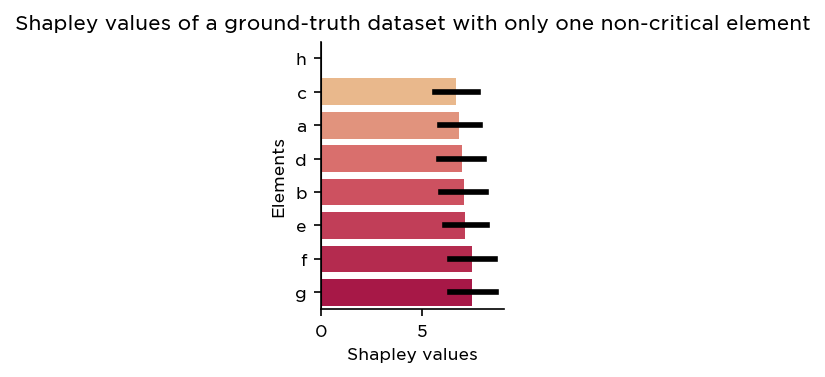

In [15]:
# The same pipeline here:
shapley_table = ut.sorter(shapley_table) # sorting based on the average contribution (Shapley values)

fig,ax = plt.subplots()
colors = pl.color_code(shapley_table=shapley_table)
pl.plot_shapley_ranks(shapley_table=shapley_table,colors=colors,ax=ax)
fig.set_dpi(150)
fig.set_size_inches((4*CM,6*CM))
plt.xlabel('Shapley values')
plt.ylabel('Elements')
plt.title('Shapley values of a ground-truth dataset with only one non-critical element')

# And the D index
d = ut.distribution_of_processing(shapley_vector=shapley_table.mean())
print(f'D intex is: {d}')

Much better! So here's the moral, in case you missed it:
The noisier the data, the less accurate Shapley values we will be. What is nice tho is the fact that even with noisy data, the ranking still makes sense. Now let's see if it scales to a large system. We'll use the same logic but on a system with 500 elements. Let's see if we can localize "the" element first.

# Scaling up to 500 elements


WARNING: This step needs about 40GB of RAM! I need to fix this later probably with dask arrays or something else. let me know if you have a solution. Also, this step shows that in principle, a large number of elements doesn't make the calculation unstable (but look below for a caveat), it makes the process computationally prohibitive. I mean, my task takes a few miliseconds but imagine a task that costs a second or two!

In [16]:
ground_truth_elements = list(range(500))
len(ground_truth_elements)

500

In [17]:
ground_truth_cause = [100] # element number 100 is the sole producer of the function

In [18]:
# Everything else is the same, again.
shapley_table, _, _ = msa.interface(
    elements=ground_truth_elements,
    n_permutations=1_000,
    objective_function=gt,
    n_parallel_games=1, # somehow all over one core is faster!
    objective_function_params={'causes': ground_truth_cause},
    random_seed=SEED)



This time we don't sort by importance but we still need to sort in ascending order to plot, in the dataframe everything is in its place but the positions are shuffled in the process or calculating Shapley values so I might later add the `shapley_table.sort_index(axis=1)` to the package itself but for now, we'll be doing it here.
We'll use scatter and line plots since barplots of this size will be very ugly.

D intex is: 0.7855553974434674


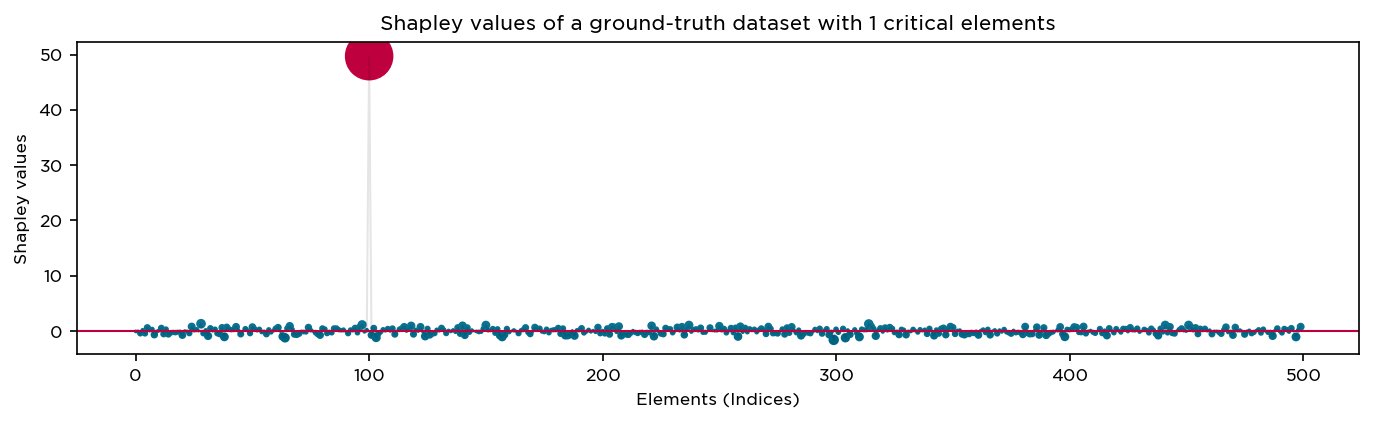

In [19]:
shapley_table = shapley_table.sort_index(axis=1)

# these are my custom color palette btw but feel free to use it. It's colorblind friendly.
color = sns.blend_palette(['#006685', '#3FA5C4', '#FFE48D', '#E84653', '#BF003F'],
                          len(ground_truth_elements),
                          as_cmap= True) 

plt.figure(figsize=(28*CM,7*CM),dpi = 150)
plt.plot(np.arange(len(ground_truth_elements)),
         shapley_table.mean(),
         c='k',linewidth=1,alpha=0.1)

plt.scatter(x = np.arange(len(ground_truth_elements)),
            y = shapley_table.mean(),
            c = shapley_table.mean(),
            s = shapley_table.mean().abs()*10,
            cmap = color)

plt.axhline(linewidth=1, color='#BF003F')
plt.xlabel('Elements (Indices)')
plt.ylabel('Shapley values')
plt.title('Shapley values of a ground-truth dataset with 1 critical elements')


# And the D index
d = ut.distribution_of_processing(shapley_vector=shapley_table.mean())
print(f'D intex is: {d}')

Works well, what doesn't work well is the D index! For sure it needs some adjustments to be more robust to the noise. But let's see if we can capture a function that is distributed over 100 nodes.

In [20]:
ground_truth_cause = list(range(100,200))

shapley_table, _, _ = msa.interface(
    elements=ground_truth_elements,
    n_permutations=1_000,
    objective_function=gt,
    n_parallel_games=1, 
    objective_function_params={'causes': ground_truth_cause},
    random_seed=SEED)

shapley_table = shapley_table.sort_index(axis=1)

D intex is: 0.9433249812188129


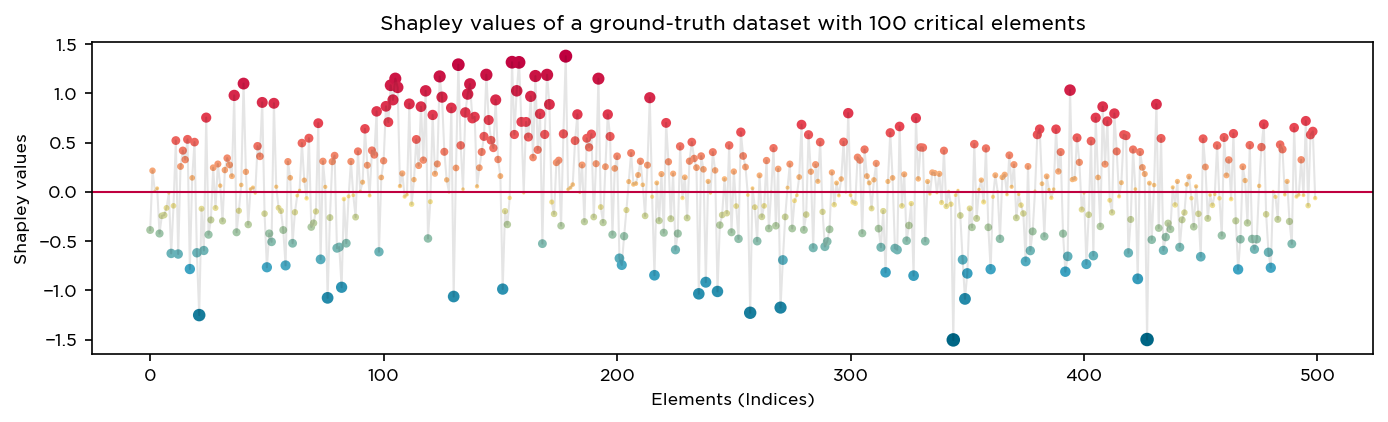

In [21]:
plt.figure(figsize=(28*CM,7*CM),dpi = 150)

plt.plot(np.arange(len(ground_truth_elements)),
         shapley_table.mean(),c='k',linewidth=1,alpha=0.1)

plt.scatter(x = np.arange(len(ground_truth_elements)),
            y = shapley_table.mean(),
            c = shapley_table.mean(),
            s = shapley_table.mean().abs()*20,
            cmap = color)

plt.axhline(linewidth=1, color='#BF003F')
plt.xlabel('Elements (Indices)')
plt.ylabel('Shapley values')
plt.title('Shapley values of a ground-truth dataset with 100 critical elements')

# And the D index
d = ut.distribution_of_processing(shapley_vector=shapley_table.mean())
print(f'D intex is: {d}')

As you can see, it didn't workout well and it actually makes sense, again remember the noise and remember that you're trying to distribute 50 points across 100 elements so although there's a noticable bump, the result is much more noisier. Let's try eliminating the performance noise.

In [22]:
shapley_table, _, lesion_effects = msa.interface(
   elements=ground_truth_elements,
   n_permutations=1_000,
   objective_function=gt_noisless,
   n_parallel_games=1, # somehow all over one core is faster!
   objective_function_params={'causes': ground_truth_cause})

shapley_table = shapley_table.sort_index(axis=1)

D intex is: 0.9045105426083806


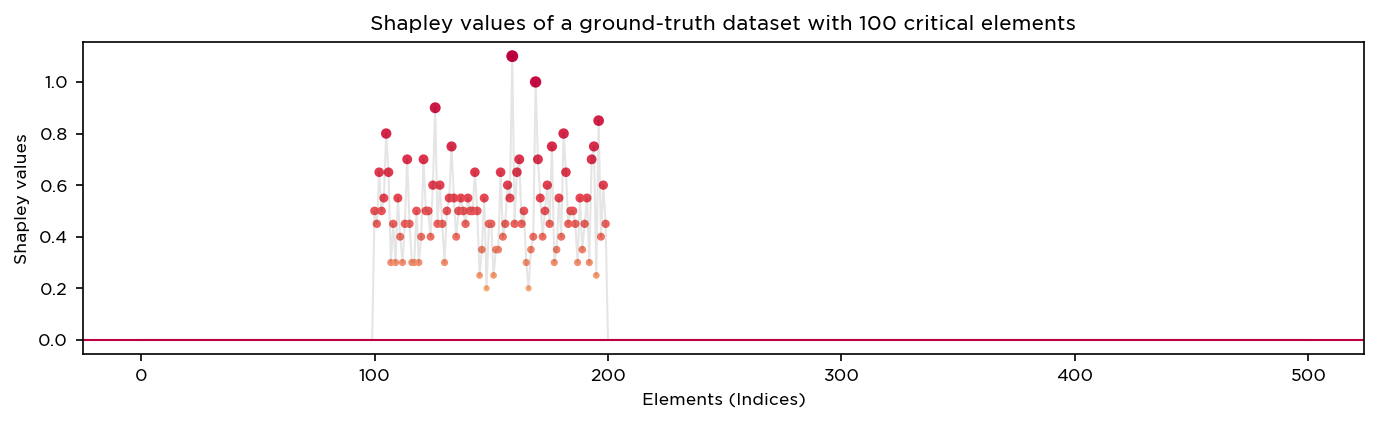

In [23]:
plt.figure(figsize=(28*CM,7*CM),dpi = 150)

color = sns.blend_palette(['#FFE48D', '#E84653', '#BF003F'], # no negative Shapley values, no cold colors
                          len(ground_truth_elements),
                          as_cmap= True) 

plt.plot(np.arange(len(ground_truth_elements)),
         shapley_table.mean(),c='k',linewidth=1,alpha=0.1)

plt.scatter(x = np.arange(len(ground_truth_elements)),
            y = shapley_table.mean(),
            c = shapley_table.mean(),
            s = shapley_table.mean().abs()*20,
            cmap = color)

plt.axhline(linewidth=1, color='#BF003F')
plt.xlabel('Elements (Indices)')
plt.ylabel('Shapley values')
plt.title('Shapley values of a ground-truth dataset with 100 critical elements')

# And the D index
d = ut.distribution_of_processing(shapley_vector=shapley_table.mean())
print(f'D intex is: {d}')

Voila! But look at the values themselves. Also look at the number of lesions performed, should be close to n_permutations*n_elements:

In [24]:
len(lesion_effects)

497856

Interestingly, this number changes but follows a normal distribution. Look:
Here I'll just use 20 elements and keep reproducing permutations and lesion combinations. Then I'll plot the histogram.

In [25]:
elements = list(range(20))

lenths = []
for i in range(1000):
    permutations = msa.make_permutation_space(elements=elements,n_permutations=1000)
    combinations = msa.make_combination_space(permutation_space=permutations)
    lenths.append(len(combinations))

Text(0.5, 1.0, 'Generated coalitions\n(from 1048576 possible coalitions)')

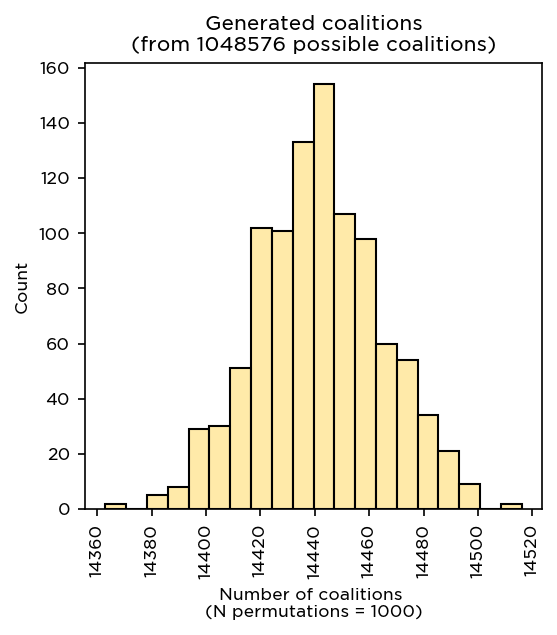

In [26]:
plt.figure(figsize=(10*CM,10*CM),dpi=150)
sns.histplot(lenths,bins=20,color = "#FFE48D")
plt.xticks(rotation=90)
plt.xlabel('Number of coalitions '
           '\n(N permutations = 1000)')
plt.title(f'Generated coalitions\n(from {2**20} possible coalitions)')
